# Model of eS6-P Regulation by Clock and Circadian Cycles

### Setup Environment

The functions required for this notebook are collected in the python module FigureModule which requires 'matplotlib' and 'tellurium'

Installation instructions can be found at the following links:
  * (Tellurium) https://github.com/sys-bio/tellurium
  * (Matplotlib) https://matplotlib.org/users/installing.html

In [1]:
import FigureModule as fm
import tellurium as te
import matplotlib.pyplot as plt

If you modify the FigureModule file and need to reload it, use the following code

In [2]:
import imp
imp.reload(fm)

<module 'FigureModule' from '/home/jupyter-panchy/RPS6_MultiModel_Visualization/Four Component Clock Testing/_GitEs6Models_SmoothInterpolation/FigureModule.py'>

## 1. Defining eS6 Phosphorylation Models

We model the dynamics of eS6 phosphorylation (eS6-P) as a system of ordinary differential equations. Each model consists of two components: a light-dependent circadian clock and eS6-P regulatory circut with both a clock-dependent regulatory pathway and a light-activated, clock-independet signaling pathway. Our models are described in Antimony format and managed using the Tellurium model in python. 

Each model is described by a text file, containing two commands which load the underlying modules (the clock module and the eS6-P module), in Antimony

In [3]:
WTLD_file='''
    import "clock_4comp_rpr_WTBase95.antimony"
    import "model_rps6_4comp.antimony"
'''

WTLL_file='''
    import "clock_4comp_rpr_LLBase95.antimony"
    import "model_rps6_4comp.antimony"
'''

CCA1_file='''
    import "clock_4comp_rpr_CCA1Base95.antimony"
    import "model_rps6_4comp.antimony"
'''

Parameter optimization for eS6-P regulation was performed with a genetic algorithm. Below are the parameters for the best fit, moderate peak model, which we used in our analysis. Modifying the parameters below will effect the results in sections 2 through 4

In [4]:
parameter_dict = {}

parameter_dict["gamma_F"] = 2.5408087135539521
parameter_dict["sigma_F"] = 4.4308954011977102
parameter_dict["w_F_O"] = -1.2310002676771672
parameter_dict["w_F_E"] = 3.8933164754013063
parameter_dict["gamma_E"] = 1.1102753863122963
parameter_dict["sigma_E"] = 1.0
parameter_dict["w_E_O"] = -2.6154810036179343
parameter_dict["w_E_S1"] = 7.7048495876494218
parameter_dict["gamma_RPS6"] = 5.2623917526960362
parameter_dict["sig_dephos"] = 1.5475161731600759
parameter_dict["sig_phos"] = 1.0851289185102639
parameter_dict["w_dephos"] = 6.5173103722429939
parameter_dict["w_phos"] = -2.2753359232542838
parameter_dict["w_RPS6_C1"] = -8.6251327900639208
parameter_dict["w_RPS6_C2"] = -8.5809480423976829
parameter_dict["w_RPS6_C3"] = 2.9449375047387378
parameter_dict["w_RPS6_C4"] = 6.5466798182305261
parameter_dict["w_RPS6_F"] = 1.44810233386896

The commands below will read the model files and update their parameters using the parameter dictionary defined above

In [5]:
WTLD_model = fm.load_model(WTLD_file,parameter_dict)
WTLL_model = fm.load_model(WTLL_file,parameter_dict)
CCA1_model = fm.load_model(CCA1_file,parameter_dict)

The contents of individual module files can be viewed using the following command

In [6]:
fm.DisplayModel(WTLD_model,format="Antimony") ### Format can be Anitmony or Matlab

// Created by libAntimony v2.9.4
function hbt(sigma, sum_omega)
  1/(1 + exp(-sigma*sum_omega));
end


// Compartments and Species:
species C1, C2, C3, C4, E, D, F, RPS6p;

// Reactions:
Clock_J00:  -> C1; gamma_C1*(hbt(sigma_C1, w_C1_O + w_C1_C3*C3 + w_C1_C4*C4 + w_C1_S1*DayNight) - C1);
Clock_J01:  -> C2; gamma_C2*(hbt(sigma_C2, w_C2_O + w_C2_C1*C1 + w_C2_C4*C4 + w_C2_C2*C2) - C2);
Clock_J02:  -> C3; gamma_C3*(hbt(sigma_C3, w_C3_O + w_C3_C4*C4 + w_C3_C2*C2 + w_C3_C1*C1 + w_C3_S1*DayNight) - C3);
Clock_J03:  -> C4; gamma_C4*(hbt(sigma_C4, w_C4_O + w_C4_C1*C1 + w_C4_C4*C4) - C4);
J01:  -> E; gamma_E*(hbt(sigma_E, w_E_O + w_E_S1*DayNight) - E);
J02:  -> F; gamma_F*(hbt(sigma_F, w_F_O + w_F_E*E) - F);
J03:  -> RPS6p; gamma_RPS6*(hbt(sig_phos, w_phos + w_RPS6_F*F)*(1 - RPS6p) - hbt(sig_dephos, w_dephos + w_RPS6_C1*C1 + w_RPS6_C2*C2 + w_RPS6_C3*C3 + w_RPS6_C4*C4)*RPS6p);

// Events:
DayNight_16_8__E0: at (avg + sin(2*pi*(time + t_shift)/period)) > 0, t0=false: DayNight = day;
DayNight_16_8

The models can also be written to SBML format using the following command

In [7]:
SBMLfile = te.antimonyToSBML(WTLD_file)
output = open("WTLD_Model.sbml","w")
output.write(SBMLfile)
output.close()

The same code can be used to generate SBML files for other models, however, some manual adjustment of parameters may be required for changes that were managed outside of the model file by python (i.e. the variation in daylength or location). This includes adjusting the time scale of the module for both the clock period (9.5 units per cycle) and light/dark ratio of the day (the module tracks light/dark by shifting a sinusoidal function up and down, which affects the postion of both dawn and dusk)

## 4. eS6 Phosphorylation in Response to Changing Seasonal Changes

*This section has been updated with the smoother interpolution of Harvard data and improved alignmented with idealized curves*


While the transient changes in dawn and dusk time indicate the sensitivity of the eS6-P model to variation in the light-dark cycle, it does not reflect the sort of slow, progressive changes observed in seasonal changes in the daylength. To investigate this, we used a solar calculator provided by National Oceanic and Atmospheric Administration (NOAA) to generate a data set of ‘ideal’ (i.e. unaffected by transient local changes) daylengths (https://www.esrl.noaa.gov/gmd/grad/solcalc/calcdetails.html). These ideal daylengths calculations were used to fit a modified light-dark cycle which varies over a simulated 365 day year

In [8]:
noaa_var_file='''
    import "clock_4comp_rpr_NOAAVar95.antimony"
    import "model_rps6_4comp.antimony"
'''

noaa_var_model = fm.load_model(noaa_var_file,parameter_dict)

We used this data to simulate eS6-P under two extremes in the day/night cycle within the range of A. thaliana: Oslo, Norway and Paria Cape Verde

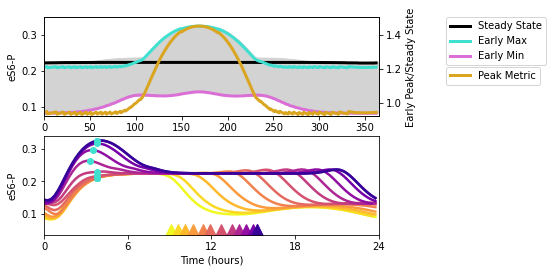

In [ ]:
plt.subplot(2, 1, 1)
fm.PlotYearlyData(noaa_var_model,parameter_dict,"Oslo")
plt.subplot(2, 1, 2)
fm.PlotDailyData(noaa_var_model,parameter_dict,"Oslo")

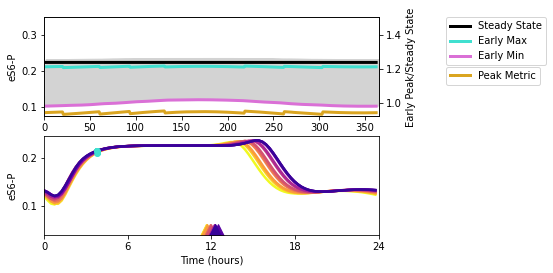

In [ ]:
plt.subplot(2, 1, 1)
fm.PlotYearlyData(noaa_var_model,parameter_dict,"Paria")
plt.subplot(2, 1, 2)
fm.PlotDailyData(noaa_var_model,parameter_dict,"Paria")

As we would expect from the previous results, we observe greater variation in eS6-P maximum and minimum values in Oslo (where days vary from ~6 to ~19 hours of light), compared to Paria (where days vary from ~11 to ~13 hours of light). This is further reflected in the peak metric (the ratio of early day peak height to saturating eS6-P value at the end of the day), which only exceeded 1 in Oslo.

However, these ideal curves only account for seasonal changes in the day-night cycle, missing transient variations due to factors like weather. So we also included a model based on downard angled photosynthetic radiation from the Harvard Forest and compared it to an ideal model of day-length variation in Boston, Massachusetts.

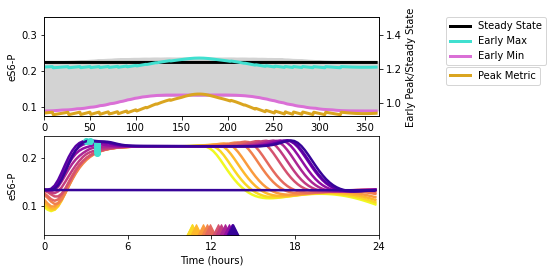

In [ ]:
plt.subplot(2, 1, 1)
fm.PlotYearlyData(noaa_var_model,parameter_dict,"Boston")
plt.subplot(2, 1, 2)
fm.PlotDailyData(noaa_var_model,parameter_dict,"Boston")

In [ ]:
hf_var_file='''
    import "Clock_4compRPR_p95_HF102_2006_SplineModel.check.antimony"
    import "model_rps6_4comp.antimony"
'''

hf_var_model = fm.load_model(hf_var_file,parameter_dict)

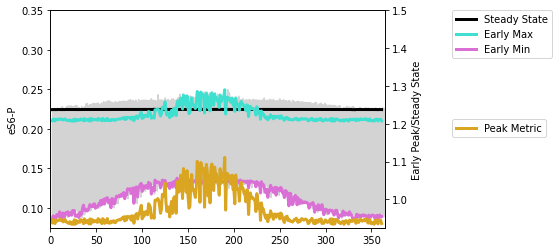

In [ ]:
fm.PlotYearlyData_HF(hf_var_model,noaa_var_model,parameter_dict)

Using Harvard Forest data, we still observe changes in maximum and minmum values of eS6-P, though the changes in peak height are more constrained compared to the ideal day lengths. The effects of random fluctuations in the day-length can be seen by comparing the peak metric between the Harvard Forest and NOAA data. Peak metric values are binned by day-length with an interval of 30 minutes.

In [ ]:
fm.PlotBinnedPeakMetric(hf_var_model,noaa_var_model,parameter_dict)

*Still see greater absolute difference between real and ideal days for days with >=13 hr, vs. those < 13 hours (5 fold differnce, pv < 2.8e-28)*